In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoModelForImageClassification, AutoProcessor,Dinov2Model
from PIL import Image
import torch.optim as optima
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
torch.__version__

'2.5.1+cu121'

In [3]:
torch.cuda.is_available()

True

In [4]:
# Paths to directories and files
root_dir = r"/Codes/MLHC_Project"
train_dir = os.path.join(root_dir, "ISIC_2020_Training_JPEG")
test_dir = os.path.join(root_dir, "ISIC_2020_Test_JPEG")
train_labels_file = os.path.join(root_dir, "ISIC_2020_Training_GroundTruth.csv")
test_labels_file = os.path.join(root_dir, "ISIC_2020_Test_Metadata.csv")

In [5]:
# Load labels
train_labels_df = pd.read_csv(train_labels_file)
test_labels_df = pd.read_csv(test_labels_file)

train_labels_df.columns = ["ImageName","PatientID","Sex","Age","AnatomySite","Diagnosis","Status","Target"]
test_labels_df.columns = ["ImageName","PatientID","Age","AnatomySite","Sex"]

# Filter necessary columns
train_labels_df = train_labels_df[["ImageName", "Target"]]
test_labels_df = test_labels_df[["ImageName"]]  # Test doesn't have target

# Add file extension to image names
train_labels_df["ImageName"] += ".jpg"
train_labels_df["Target"] = train_labels_df["Target"].astype(str)
test_labels_df["ImageName"] += ".jpg"

In [6]:
# Split train data into train and validation sets
train_df, val_df = train_test_split(
    train_labels_df, 
    test_size=0.1, 
    stratify=train_labels_df["Target"], 
    random_state=42
)

In [7]:
class ISICDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = int(self.dataframe.iloc[idx, 1]) if 'Target' in self.dataframe.columns else -1
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Define transformations (augmentation for train, basic for val and test)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [9]:
# Prepare datasets and dataloaders
train_dataset = ISICDataset(train_df, train_dir, transform=train_transform)
val_dataset = ISICDataset(val_df, train_dir, transform=val_test_transform)
test_dataset = ISICDataset(test_labels_df, test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Load the model
model = AutoModelForImageClassification.from_pretrained("facebook/dinov2-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced", 
                                     classes = np.unique(train_labels_df["Target"].astype(int)),
                                     y = train_labels_df["Target"].astype(int)
                                    )

class_weights = torch.tensor(class_weights,dtype = torch.float).to(device)

In [12]:
class_weights

tensor([ 0.5090, 28.3613], device='cuda:0')

In [13]:
# Define optimizer and loss function
optimizer = optima.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight = class_weights)

# Define save paths for model weights
results_dir = "/Codes/MLHC_Project/results"
os.makedirs(results_dir, exist_ok=True)
model_save_path_last_epoch = os.path.join(results_dir, "dinov2_metadata_weightedmodel_best_weights.pth")
best_accuracy = 0.0

In [14]:
from sklearn.metrics import *
import matplotlib.pyplot as plt

# Load the model
model = AutoModelForImageClassification.from_pretrained("facebook/dinov2-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_save_path_last_epoch))
model.to(device)
model.eval()

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArrunPersonal\AppData\Local\Temp\ipykernel_4172\2541524950.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [15]:
# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training phase
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images, labels=labels)
        logits = outputs.logits  # Get the logits from the model output

        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, preds = torch.max(logits, 1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    avg_train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f} - Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images, labels=labels)
            logits = outputs.logits

            loss = criterion(logits, labels)
            val_loss += loss.item()

            _, preds = torch.max(logits, 1)
            correct_predictions += torch.sum(preds == labels).item()
            total_predictions += labels.size(0)

    val_accuracy = correct_predictions / total_predictions
    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

    # Save the model if this is the best validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), model_save_path_best)
        print(f"Best model saved with accuracy: {best_accuracy:.4f}")

# Save model weights for the last epoch
torch.save(model.state_dict(), model_save_path_last_epoch)
print("Model weights from the last epoch saved.")

Epoch 1/3 - Training:  54%|█████▍    | 503/932 [2:19:46<1:59:12, 16.67s/it]


MemoryError: 

In [15]:
from sklearn.metrics import *
import matplotlib.pyplot as plt

# Load the model
model = AutoModelForImageClassification.from_pretrained("facebook/dinov2-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_save_path_last_epoch))
model.to(device)
model.eval()

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArrunPersonal\AppData\Local\Temp\ipykernel_4172\2541524950.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch

Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [ ]:
from torch.nn.functional import softmax

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels, *_ in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)  # Forward pass
        logits = outputs.logits  # Extract logits
        probabilities = softmax(logits, dim=1)  # Compute softmax

        preds = probabilities.argmax(dim=1)  # Predicted class
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())


Validation:   5%|▍         | 5/104 [00:20<06:47,  4.12s/it]

In [ ]:
# Convert to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

In [18]:
np.unique(all_preds)

array([0, 1], dtype=int64)

In [19]:
np.unique(all_labels)

array([0, 1], dtype=int64)

In [20]:
np.shape(all_labels),np.shape(all_preds),np.shape(all_probs)

((3313,), (3313,), (3313, 2))

In [21]:
# Accuracy, Precision, Recall, F1
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="macro")
recall = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

In [22]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.9728
Precision: 0.5192
Recall: 0.5120
F1-Score: 0.5144


In [23]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[3221   34]
 [  56    2]]


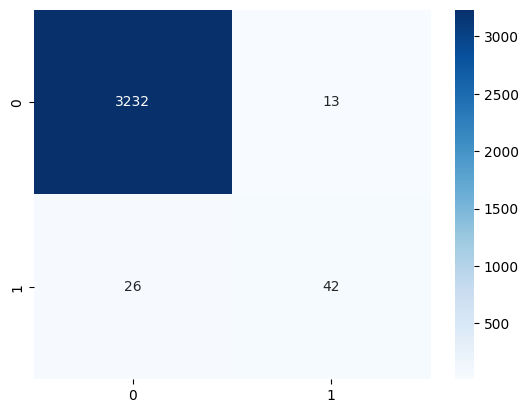

In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define the confusion matrix
cf_matrix = np.array([[3232,13],[26,42]], dtype='int64')

# Plot the heatmap with the 'Blues' colormap and integer annotations
sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
plt.show()

ROC AUC Score: 0.77


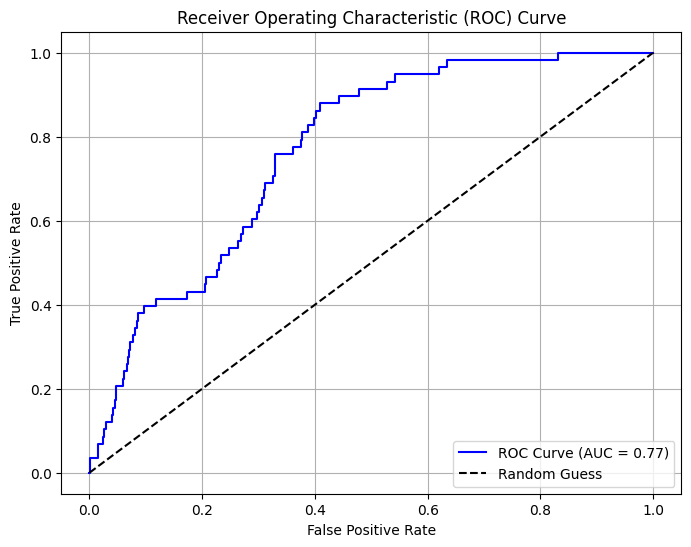

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming all_labels and all_probs are correctly defined
fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_probs])  # Positive class probabilities
roc_auc_score = auc(fpr, tpr)  # Correctly named variable

# Print ROC AUC score
print(f"ROC AUC Score: {roc_auc_score:.2f}")

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [25]:
print(classification_report(all_labels,all_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3255
           1       0.06      0.03      0.04        58

    accuracy                           0.97      3313
   macro avg       0.52      0.51      0.51      3313
weighted avg       0.97      0.97      0.97      3313



Area under Precision-Recall Curve (AUPR): 0.05


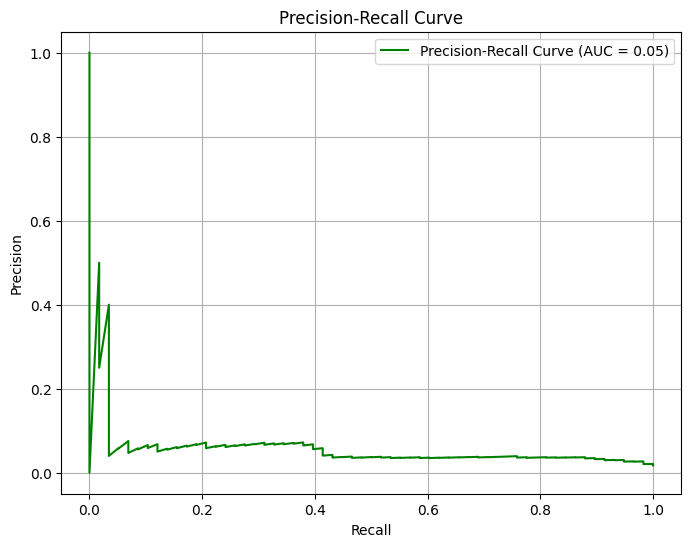

In [26]:
precision, recall, _ = precision_recall_curve(all_labels, [p[1] for p in all_probs])

# Compute Area Under Precision-Recall Curve (AUPR)
pr_auc = auc(recall, precision)

# Print AUPR score
print(f"Area under Precision-Recall Curve (AUPR): {pr_auc:.2f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()